# Семинар 11
## [Transformers. Attention is all you need.](https://arxiv.org/abs/1706.03762)

Содержание:
* Multihead-self attention
* Layer norm
* Dropout
* Positional encoding
* Encoder
* Decoder
* Masks

https://wikidocs.net/31379   
https://lilianweng.github.io/posts/2018-06-24-attention/#multi-head-self-attention   
https://jalammar.github.io/illustrated-transformer/   
https://nlp.seas.harvard.edu/2018/04/03/attention.html   

In [ ]:
from IPython.display import Image

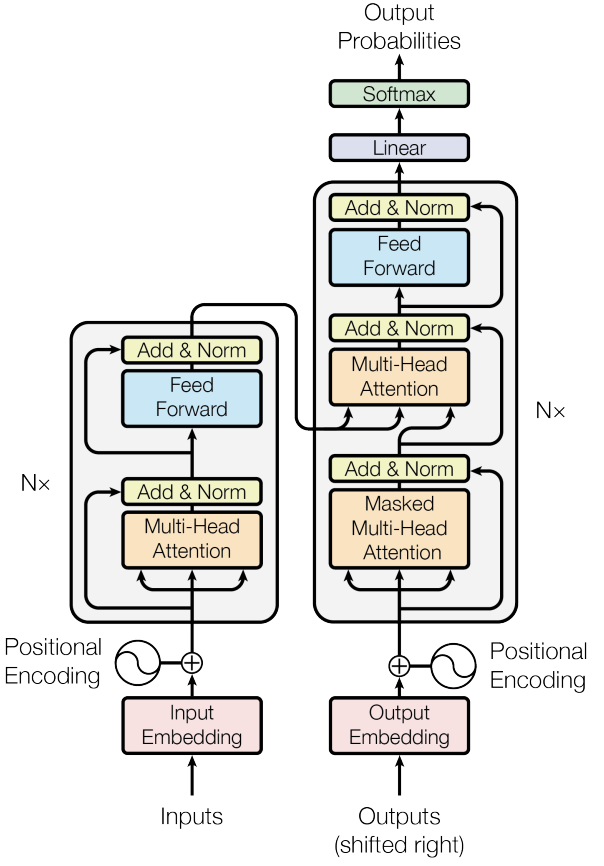

In [4]:
Image(filename = './transformers/2.png', width=600, height=500)

* Архитектура Encoder-Decoder, как и у seq2seq
* Можно и many-to-one, используем только encoder
* Decoder: авторегрессионная модель, self-attention + causal attention mask
* Transformer base: N=6, d=512, dff=4d=2048

## Pre-processing data

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

In [2]:
# Задача классификация рецензий на фильмы
from torchtext.datasets import IMDB

def get_dataset(split='train'):
    dataset = IMDB('./data', split=split)
    texts, targets = [], []
    
    for label, text in dataset:
        targets += [1 if label == 'pos' else 0]
        texts += [text]
    
    return pd.DataFrame({'raw_text': texts, 'target': targets})

In [3]:
train_set = get_dataset('train')
test_set = get_dataset('test')
train_set.shape, test_set.shape

/home/ivanov/envs/check_pruning/lib/python3.9/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/ivanov/envs/check_pruning/lib/python3.9/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


((25000, 2), (25000, 2))

In [4]:
train_set.head()

raw_text  target
0  Zentropa has much in common with The Third Man...       1
1  Zentropa is the most original movie I've seen ...       1
2  Lars Von Trier is never backward in trying out...       1
3  *Contains spoilers due to me having to describ...       1
4  That was the first thing that sprang to mind a...       1

In [5]:
train_set.loc[101]['raw_text']

'When I was a kid I watched this many times over, and I remember whistling the "Happy Cat" song quite often. All the songs are great, and actually memorable, unlike many children\'s musicals, where the songs are just stuck in for no real reason. The scenes and costumes are lavish, and the acting is very well-done, which isn\'t surprising, considering the cast. Christopher Walken is very catlike, and doesn\'t need stupid make-up, or a cat costume for the viewer to believe he\'s a cat transformed to a human. And Jason Connery\'s so cute, as the shy and awkward miller\'s son, Corin, who falls in love with beautiful and the bold Princess Vera. This is a really fun, enjoyable, feature-length movie, where unlike most fairytales, the characters are given personalities. Some of my favourite parts are when Puss makes Corin pretend he\'s drowning; at the ball when everybody starts dancing a country dance, as it\'s "all the rage abroad"; when Walken is in the kitchen, dancing on the table (he\'s 

In [6]:
# NLTK - пакет библиотек и программ для символьной и статистической обработки естественного языка,.
import nltk
# Стоп слова - часто встречающиеся слова, которые не несут полезной информации. (артикли например)
from nltk.corpus import stopwords
# Токенайзер - разбивает текст на токены, т. е. на подстроки для нахождения слов и знаков пунктуации
from nltk.tokenize import word_tokenize
# Лемматизация - приведение слова к нормальному виду (единственное число именительный падеж). 
# Приведение разных форм слова к одному
from nltk.stem import WordNetLemmatizer

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /home/ivanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ivanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ivanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ivanov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
list(stop_words)[:10]

['needn',
 'while',
 'for',
 "should've",
 "shan't",
 "needn't",
 'will',
 'didn',
 'my',
 'm']

In [30]:
text = 'Hello! My World 42. These worlds better then this but not so good.'
word_tokenize(text.lower())

['hello',
 '!',
 'my',
 'world',
 '42.',
 'these',
 'worlds',
 'better',
 'then',
 'this',
 'but',
 'not',
 'so',
 'good',
 '.']

In [8]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
#     print(text)
    text = list(lemmatizer.lemmatize(word) for word in text)
#     print(text)
    text = list(word for word in text if word not in stop_words)
#     print(text)
    return ' '.join(text)

In [10]:
train_set['text'] = train_set.apply(lambda row: preprocess(row.raw_text), axis=1)
test_set['text'] = test_set.apply(lambda row: preprocess(row.raw_text), axis=1)

In [11]:
train_set.loc[101]['text']

'wa kid watched many time remember whistling happy cat song quite often song great actually memorable unlike many child musical song stuck real reason scene costume lavish acting surprising considering cast christopher walken catlike doe need stupid cat costume viewer believe cat transformed human jason connery cute shy awkward miller son corin fall love beautiful bold princess vera really fun enjoyable movie unlike fairytale character given personality favourite part pus make corin pretend drowning ball everybody start dancing country dance rage abroad walken kitchen dancing table pretty good dancer vera tell corin thing used wa young like pretending wa miller daughter recommend film child parent alike love magic fairytale actually movie watch together wo drive adult wall'

## Baseline

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [13]:
tf_idf = TfidfVectorizer().fit(train_set['text'])
train_tf_idf = tf_idf.transform(train_set['text'])
test_tf_idf = tf_idf.transform(test_set['text'])

In [14]:
log_regr = LogisticRegression(n_jobs=-1).fit(train_tf_idf, train_set['target'])

In [15]:
print(f'Train acc: {accuracy_score(train_set["target"],log_regr.predict(train_tf_idf)):.4f}')
print(f'Test acc: {accuracy_score(test_set["target"], log_regr.predict(test_tf_idf)):.4f}')

Train acc: 0.9330
Test acc: 0.8783


## Tokenizing data

In [16]:
from torchtext.vocab import build_vocab_from_iterator

def dataset_iterator(texts):
    for text in texts:
        yield text.split()

In [17]:
vocab = build_vocab_from_iterator(
    dataset_iterator(train_set['text']),
    specials=['<pad>', '<unk>'], min_freq=10,
)

In [20]:
train_tokens = []
for text in dataset_iterator(train_set['text']):
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    train_tokens += [tokens]

test_tokens = []
for text in dataset_iterator(test_set['text']):
    tokens = [vocab[word] if word in vocab else vocab['<unk>'] for word in text]
    test_tokens += [tokens]

In [25]:
train_tokens

[[11449,
  8,
  22,
  968,
  674,
  54,
  73,
  5,
  121,
  622,
  13022,
  11706,
  2037,
  7,
  1,
  22,
  3881,
  258,
  58,
  1117,
  174,
  15,
  1895,
  447,
  69,
  19,
  18,
  272,
  484,
  12469,
  2909,
  1814,
  2,
  2,
  44,
  674,
  54,
  8,
  609,
  11449,
  111,
  3662,
  912,
  262,
  6013,
  1174,
  155,
  3656,
  12,
  1958,
  142,
  2,
  2,
  4,
  1,
  2326,
  1315,
  6,
  186,
  6,
  46,
  17,
  2438,
  1806,
  2326,
  1545,
  2288],
 [11449,
  107,
  4,
  42,
  50,
  7,
  788,
  534,
  3697,
  5,
  1315,
  105,
  3658,
  240,
  1256,
  1985,
  1,
  460,
  91,
  2335,
  5095,
  7,
  2251,
  1788,
  1594,
  7079,
  18,
  51,
  58,
  5066,
  112,
  3694,
  684,
  295,
  1871,
  708,
  350,
  368,
  26,
  689,
  16724,
  258,
  1788,
  559,
  170,
  44,
  3154,
  149,
  298,
  5532,
  194,
  1569,
  319,
  2384,
  17169,
  8051,
  329,
  200],
 [7512,
  2335,
  5095,
  46,
  9710,
  169,
  77,
  1661,
  107,
  292,
  51,
  2,
  2,
  4032,
  11706,
  2019,
  6915,
  107

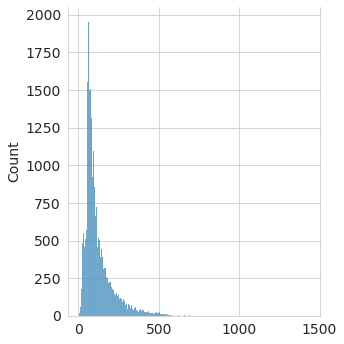

In [22]:
lengths = np.array([len(tokens) for tokens in train_tokens])
sns.displot(lengths)
plt.show()

In [23]:
max_length = 300
# Количество предложений, максимальная длина предложений
tokenized_train = torch.full((len(train_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(train_tokens):
    length = min(max_length, len(tokens))
    tokenized_train[i, :length] = torch.tensor(tokens[:length])

tokenized_test = torch.full((len(test_tokens), max_length), vocab['<pad>'], dtype=torch.int32)
for i, tokens in enumerate(test_tokens):
    length = min(max_length, len(tokens))
    tokenized_test[i, :length] = torch.tensor(tokens[:length])

In [24]:
tokenized_train

tensor([[11449,     8,    22,  ...,     0,     0,     0],
        [11449,   107,     4,  ...,     0,     0,     0],
        [ 7512,  2335,  5095,  ...,     0,     0,     0],
        ...,
        [  118,     4,     3,  ...,     0,     0,     0],
        [    5,   323,     1,  ...,     0,     0,     0],
        [  306,     1,  3832,  ...,     0,     0,     0]], dtype=torch.int32)

In [26]:
targets_train = torch.tensor(train_set['target'], dtype=torch.int32)
targets_test = torch.tensor(test_set['target'], dtype=torch.int32)

In [27]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(tokenized_train, targets_train)
test_dataset = TensorDataset(tokenized_test, targets_test)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

## Transformer architecture

Вход - [BS, L, D], BS- batch size, L - длина последовательности, D - размер эмбединга
Добиваем PAD - ами предложения чтобы их выровнять в одном батче.

Токен PAD служебный, мы не хотим, чтобы модель на нем училась
Добавим матрице внимания маску:
0  для токенов, -10^9 для PAD, softmax убьёт это значение

Поскольку мы можем просчитать внимание за одну матричную операцию, мы потеряли информацию о взаимном расположении токенов  
Значит положение токенов нужно задать руками  
Хотелось бы чтобы:  
* сохранялось относительное положение
* значение признака было ~ 1
* Можно равномерно расставить все токены вдоль окружности взять cos и sin угла, получаем 2 значения на каждый токен
* Можно брать много расстановок с разным шагом, получим больше значений
* Конкатенация векторов для всех углов


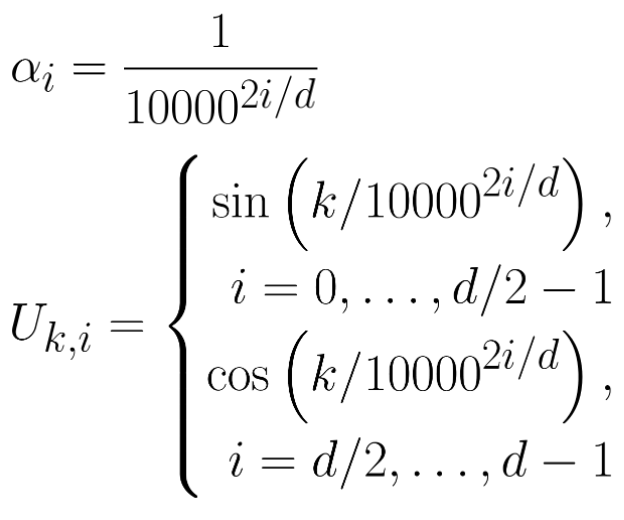

In [6]:
Image(filename = './transformers/16.png', width=600, height=500)

In [31]:
import math
from torch import nn

class PositionalEncoder(nn.Module):
    # Adapted from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, max_length, embed_dim, dropout):
        super().__init__()
        self.pos_features = torch.zeros(max_length, embed_dim)

        positions = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        freqs = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) * \
                          (-math.log(10000) / embed_dim)).unsqueeze(0)

        arguments = positions * freqs
        self.pos_features[:, 0::2] = torch.sin(arguments)
        self.pos_features[:, 1::2] = torch.cos(arguments)
        self.pos_features = self.pos_features.unsqueeze(0)
        self.pos_features = nn.Parameter(self.pos_features, requires_grad=False)
        # pos_features: (1, max_length(длина предложения), embed_dim (размер векторного представления))

        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        outputs = inputs + self.pos_features[:, :inputs.shape[1]]
        return self.dropout(outputs)

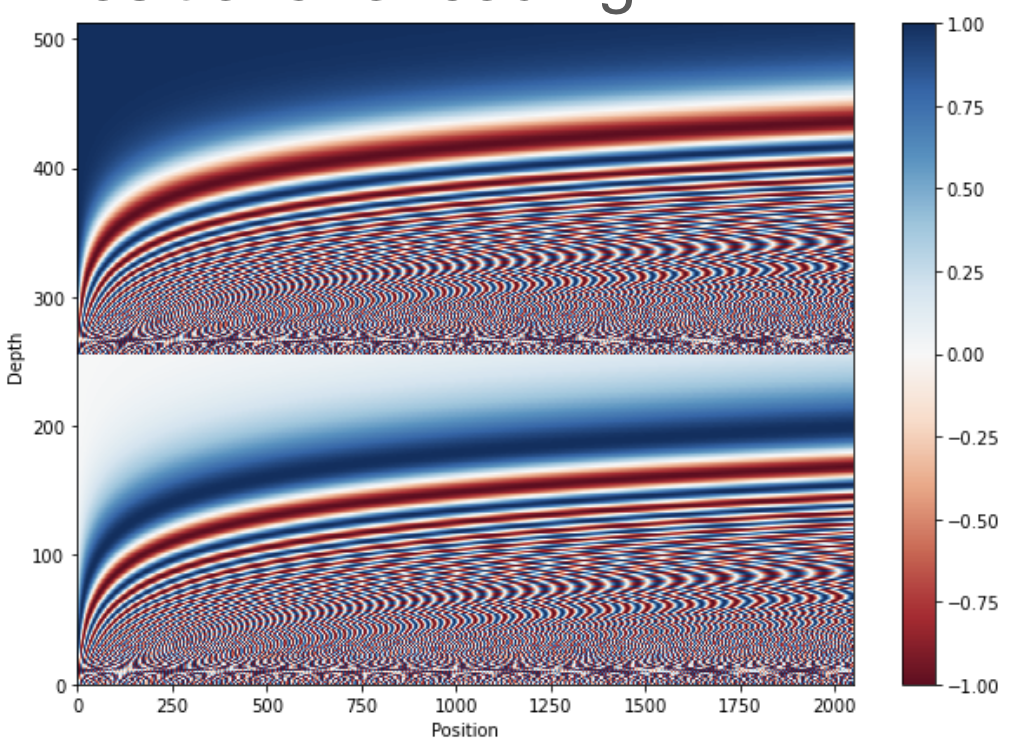

In [7]:
Image(filename = './transformers/15.png', width=600, height=500)

# Multihead self-attention

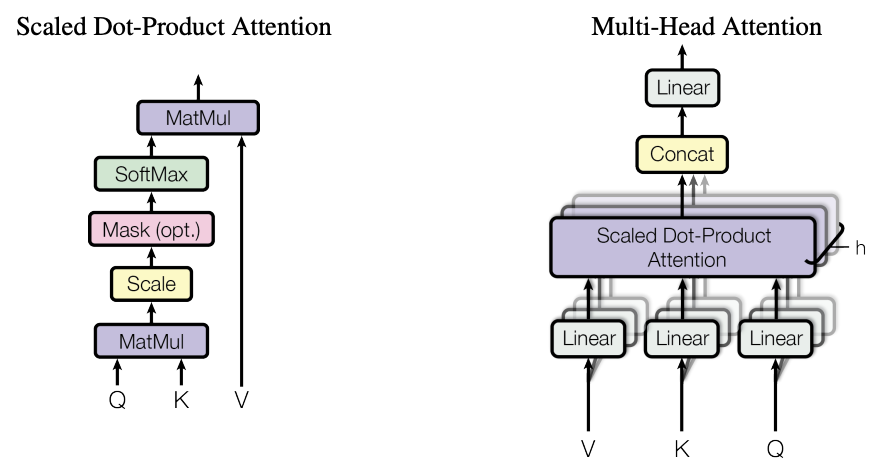

In [8]:
Image(filename = './transformers/3.png', width=600, height=500)

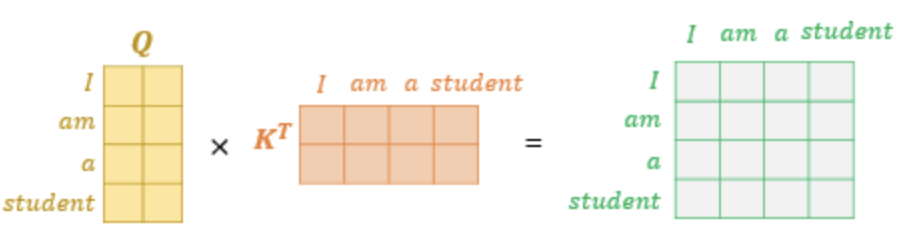

In [16]:
Image(filename = './transformers/17.png', width=600, height=500)

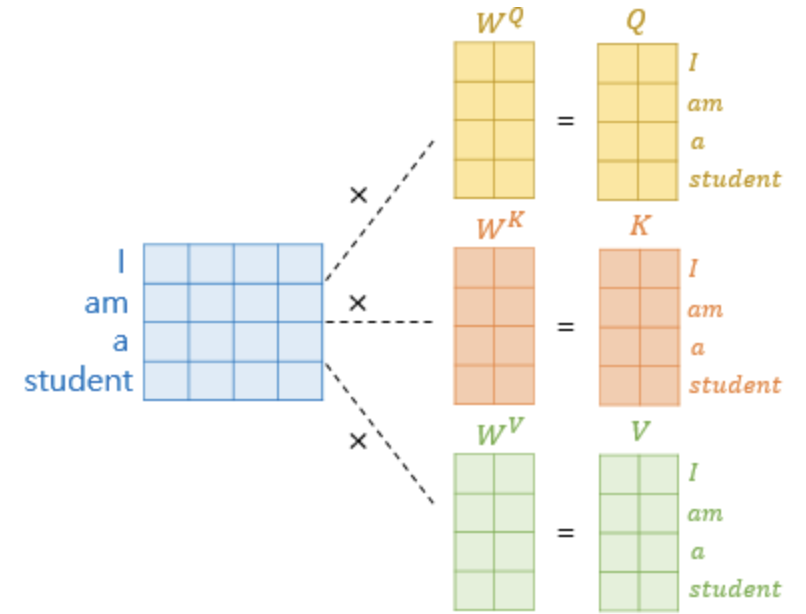

In [17]:
Image(filename = './transformers/18.png', width=600, height=500)

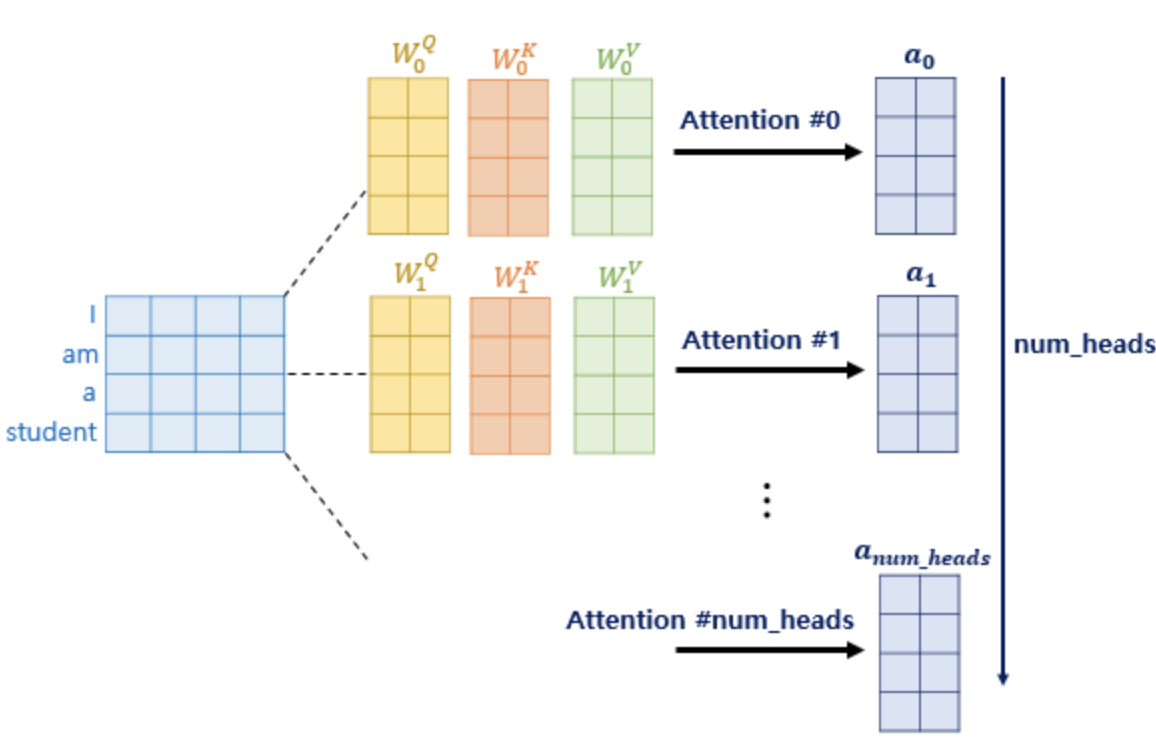

In [18]:
Image(filename = './transformers/19.png', width=600, height=500)

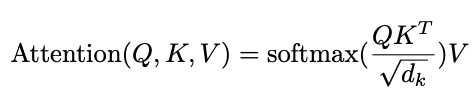

In [9]:
Image(filename = './transformers/4.png', width=600, height=500)

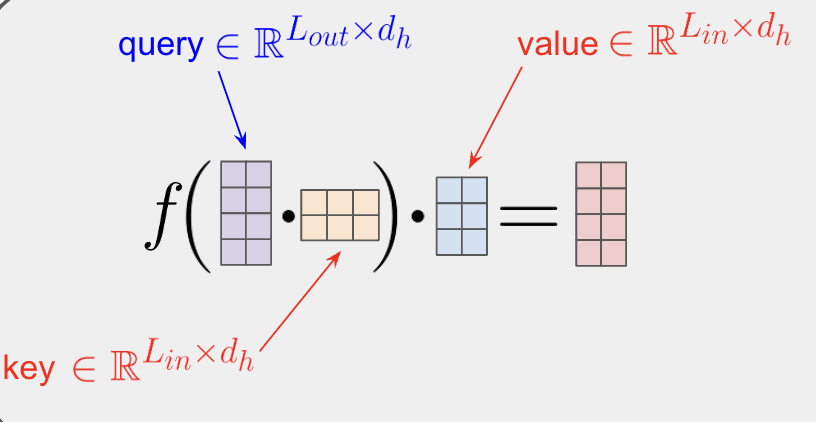

In [19]:
Image(filename = './transformers/13.png', width=600, height=500)

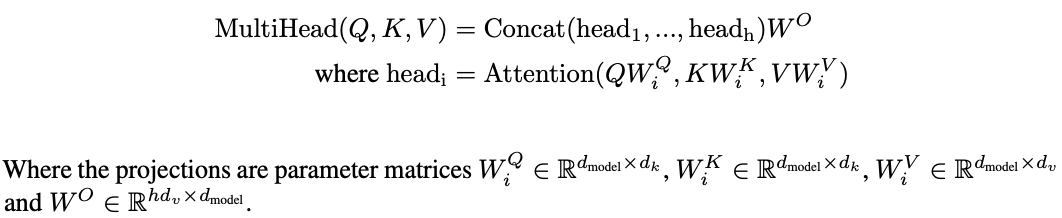

In [20]:
Image(filename = './transformers/5.png', width=600, height=500)

Ансамбли нейронных сетей   
Обучение нейронных сетей это не детерминистский процесс   
Случайность появляется на различных этапах обучения:   
* инициализация весов, порядок, в котором предъявляются элементы обучающего множества
* Если одну и ту же архитектуру обучить несколько раз на одних и тех же данных, результаты будут немного различаться
* Консенсусное мнение ансамбля сетей, как правило, показывает лучший результат, чем каждая сеть взятая отдельно
Dropout регуляризация    
* Способ динамически выделять во время обучения случайную подсеть внутри сети, во время inference они работают вместе

Консенсусное мнение   
Получается применением полносвязного слоя к конкатенации вывода всех голов

In [32]:
class Attention(nn.Module):
    # Single-head attention
    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        # Для упрощения вычислений и для матричных операций
        attention_dim = embed_dim // num_heads

        self.WQ = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WK = nn.Linear(embed_dim, attention_dim, bias=False)
        self.WV = nn.Linear(embed_dim, attention_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value: (batch_size, length, embed_dim)
        # mask: (batch_size, length, length)

        Q = self.WQ(query)
        K = self.WK(key)
        V = self.WV(value)
        # Q, K, V: (batch_size, length, attention_dim)

        norm_factor = math.sqrt(Q.shape[-1])
        dot_products = torch.bmm(Q, K.transpose(1, 2)) / norm_factor
        # dot_products: (batch_size, length, length)

        if mask is not None:
            dot_products = dot_products.masked_fill(mask, -math.inf)

        attention_score = nn.functional.softmax(dot_products, dim=-1)
        attention = torch.bmm(self.dropout(attention_score), V)
        # attention_score: (batch_size, length, length)
        # attention: (batch_size, length, attention_dim)

        return attention, attention_score


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()

        assert embed_dim % num_heads == 0
        self.attention_heads = nn.ModuleList([Attention(embed_dim, num_heads, dropout)
                                              for _ in range(num_heads)])

        self.linear = nn.Linear(embed_dim, embed_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query, key, value: (batch_size, length, embed_dim)
        # mask: (batch_size, length, length)
        attentions, attention_scores = [], []

        for head in self.attention_heads:
            attention, attention_score = head(query, key, value, mask)
            attentions += [attention]
            attention_scores += [attention_score]

        attentions = torch.cat(attentions, dim=-1)
        attention_scores = torch.stack(attention_scores, dim=-1)
        # attentions: (batch_size, length, embed_dim)
        # attention_scores: (batch_size, length, length, num_heads)

        outputs = self.linear(attentions)
        outputs = self.dropout(outputs)
        # outputs: (batch_size, length, embed_dim)

        return outputs, attention_scores

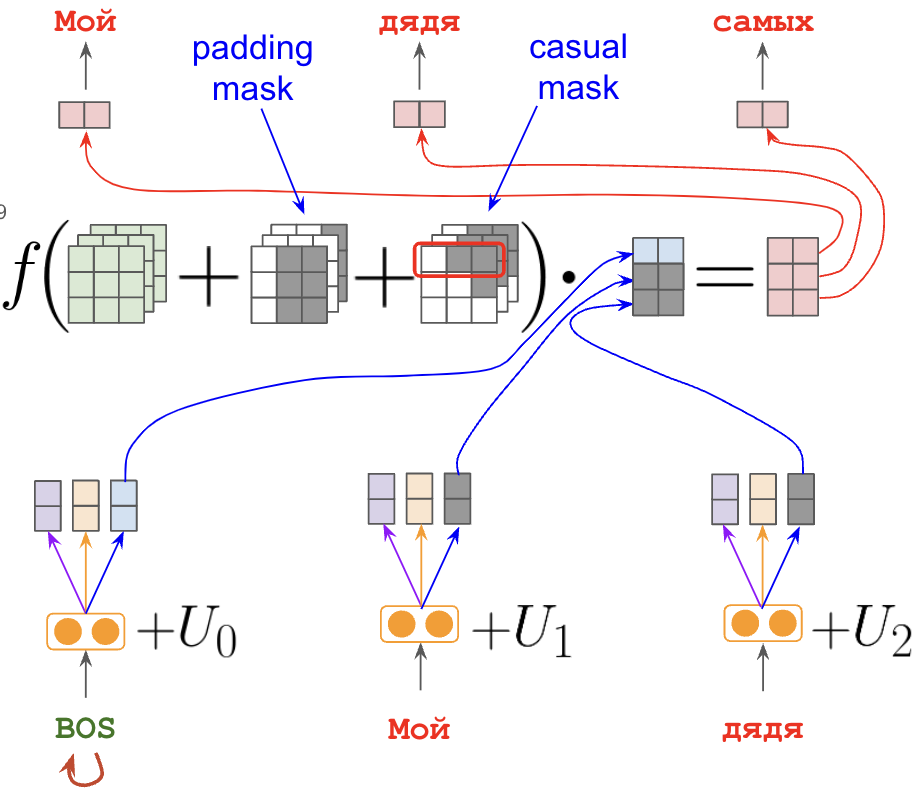

In [12]:
Image(filename = './transformers/12.png', width=600, height=500)

In [34]:
def create_padding_mask(tokens, pad_idx=vocab['<pad>']):
    # tokens: (batch_size, length)
    length = tokens.shape[-1]
    padding_mask = (tokens == pad_idx)
    padding_mask = padding_mask.unsqueeze(1).repeat(1, length, 1)
    # padding_mask: (batch_size, length, length)

    return padding_mask

# Layer norm
https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

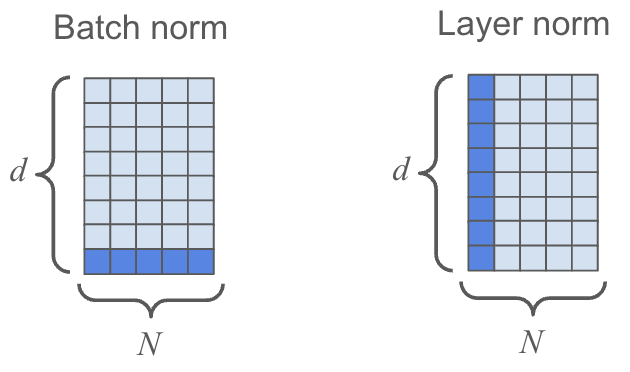

In [13]:
Image(filename = './transformers/8.png', width=600, height=500)

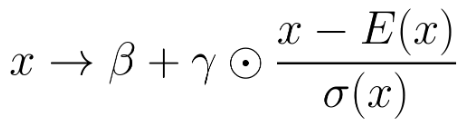

In [14]:
Image(filename = './transformers/9.png', width=600, height=500)

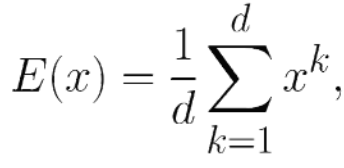

In [15]:
Image(filename = './transformers/10.png', width=600, height=500)

In [35]:
class TransformerLayer(nn.Module):
    def __init__(self, embed_dim, fc_dim, num_heads, dropout):
        super().__init__()
        self.self_attention = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inputs, mask):
        attention, attention_score = self.self_attention(
            query=inputs, 
            key=inputs, 
            value=inputs, 
            mask=mask)
        outputs = inputs + attention
        outputs = self.norm1(outputs)
        outputs = outputs + self.feedforward(outputs)
        outputs = self.norm2(outputs)
        return outputs, attention_score


class Transformer(nn.Module):
    def __init__(self, vocab_size, max_length, num_classes,
                 embed_dim, fc_dim, num_heads, num_layers, dropout):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoder(max_length, embed_dim, dropout)
        self.layers = nn.ModuleList([TransformerLayer(embed_dim, fc_dim, num_heads, dropout) \
                                     for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, tokens):
        # source: (batch_size, length)
        embeds = self.embedding(tokens) * math.sqrt(self.embed_dim)
        outputs = self.pos_encoder(embeds)
        # outputs: (batch_size, length, embed_dim)

        padding_mask = create_padding_mask(tokens)
        attention_scores = []
        for layer in self.layers:
            outputs, attention_score = layer(outputs, padding_mask)
            attention_scores += [attention_score]
        attention_scores = torch.stack(attention_scores, dim=-1)
        # outputs: (batch_size, length, embed_dim)
        # attentions_scores: (batch_size, length, embed_dim, num_heads, num_layers)

        mask = (tokens != vocab['<pad>']).to(torch.float).detach()
        lengths = mask.sum(dim=1).detach()
        outputs = (outputs * mask.unsqueeze(2)).sum(dim=1) / lengths.unsqueeze(1)
        # outputs: (batch_size, embed_dim)

        logits = self.classifier(outputs)
        # logits: (batch_size, num_classes)

        return logits, attention_scores

In [36]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Transformer(vocab_size=len(vocab), max_length=max_length, num_classes=1,
                    embed_dim=64, fc_dim=64, num_heads=4, num_layers=4, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [39]:
sum(param.numel() for param in model.parameters())

1225025

## Training

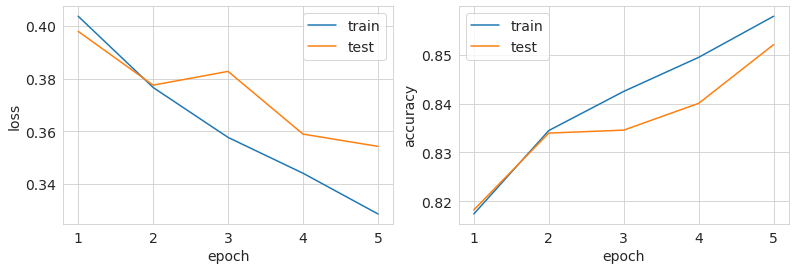

Best test accuracy: 0.85204


In [41]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        logits, _ = model(tokens)
        probs = torch.sigmoid(logits.squeeze(1))
        loss = criterion(probs, labels.to(torch.float))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()
        
    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for tokens, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        tokens = tokens.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits, _ = model(tokens)
            probs = torch.sigmoid(logits.squeeze(1))
            loss = criterion(probs, labels.to(torch.float))
        
        running_loss += loss.item() * tokens.shape[0]
        running_accuracy += ((probs > 0.5).to(torch.int) == labels).sum().item()
        
    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')

## Visualizing attention scores

In [42]:
tokens = tokens[:1]

In [44]:
tokens = tokens[:, :29]

In [46]:
with torch.no_grad():
    logits, scores = model(tokens)

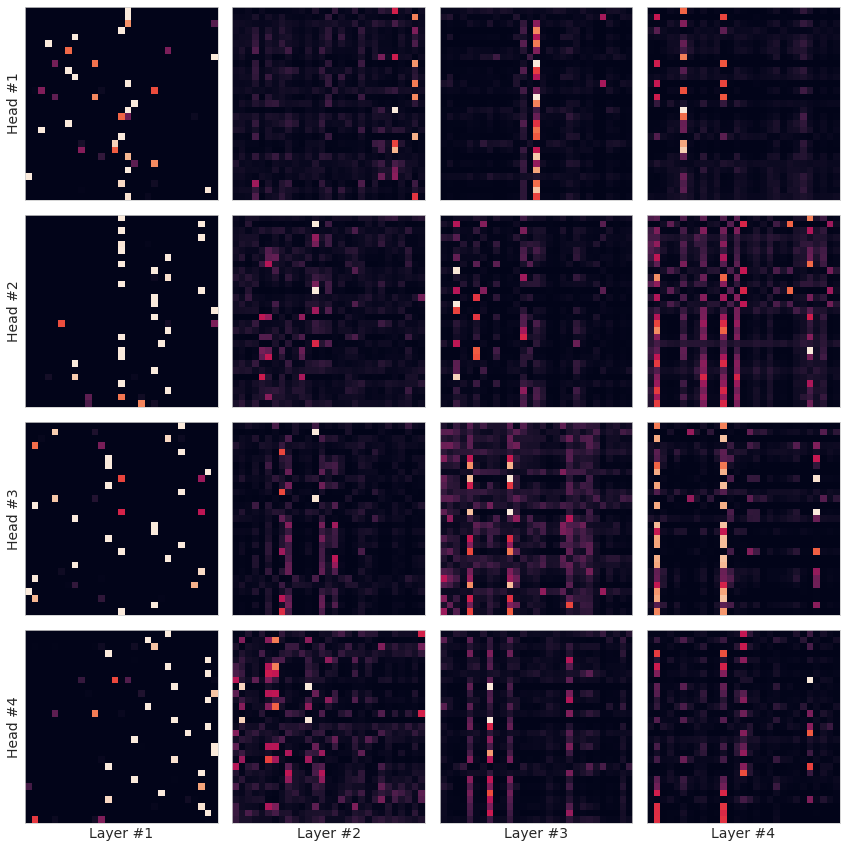

In [47]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(4):
    axs[i, 0].set_ylabel(f'Head #{i + 1}')
    axs[-1, i].set_xlabel(f'Layer #{i + 1}')
    for j in range(4):
        axs[i, j].imshow(scores[0, ..., i, j].cpu().numpy())
        axs[i, j].grid()
        axs[i, j].xaxis.set_ticks([])
        axs[i, j].yaxis.set_ticks([])

plt.tight_layout()
plt.show()

In [49]:
words = [vocab.get_itos()[token] for token in tokens.squeeze().cpu().numpy()]

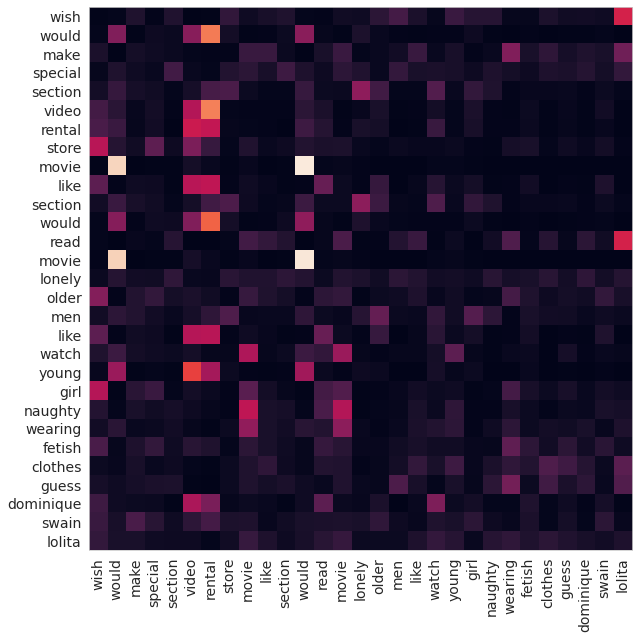

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.imshow(scores[0, ..., 3, 1].cpu().numpy())
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words)

plt.grid()
plt.show()